# imports

In [1]:
import os
environment = os.environ.get("KAGGLE_KERNEL_RUN_TYPE", "")

In [2]:
import sys

if environment:
    sys.path.append("../input/efficientnet-pytorch")
    !pip install -q --no-index --find-links="/kaggle/input/segmentation-models-pytorch" segmentation_models_pytorch 
    sys.path.append("/kaggle/input/timm-pretrained-resnest/resnest/")
    !pip install -q /kaggle/input/torchsummary/torchsummary-1.5.1-py3-none-any.whl


In [3]:
import torch
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup
from torch.optim import AdamW
import torch.nn as nn
from torchmetrics.functional import dice
import torchvision.transforms as T


import warnings

warnings.filterwarnings("ignore")

import os
import yaml
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pprint import pprint
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
import seaborn as sns

from torchsummary import summary

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
if environment: 
    !mkdir -p /root/.cache/torch/hub/checkpoints/
    !cp /kaggle/input/timm-pretrained-resnest/resnest/gluon_resnest26-50eb607c.pth /root/.cache/torch/hub/checkpoints/gluon_resnest26-50eb607c.pth

# Configs

In [5]:
%%writefile config.yaml

data_path: "/kaggle/input/contrails-images-ash-color"
output_dir: "models"
train: False

seed: 420

train_bs: 24
valid_bs: 128
workers: 2

progress_bar_refresh_rate: 1

early_stop:
    monitor: "val_loss"
    mode: "min"
    patience: 999
    verbose: 1

trainer:
    max_epochs: 32
    min_epochs: 29
    enable_progress_bar: True
    precision: "16-mixed"
    devices: 2
    

model:
    
    seg_model: "Unet"
#     seg_model: "Unet++"
#     encoder_name: "efficientnet-b3"
    encoder_name: 'timm-resnest50d'
    loss_smooth: 1.0
    image_size: 384
    optimizer_params:
        lr: 0.0008
        weight_decay: 0.0001
    scheduler:
        name: "CosineAnnealingLR"
        params:
            CosineAnnealingLR:
                T_max: 2
                eta_min: 1.0e-6
                last_epoch: -1
            ReduceLROnPlateau:
                mode: "min"
                factor: 0.31622776602
                patience: 4
                verbose: True
            cosine_with_hard_restarts_schedule_with_warmup:
                num_warmup_steps: 350
                num_training_steps: 31500
                num_cycles: 1

Writing config.yaml


In [6]:
with open("config.yaml", "r") as file_obj:
    config = yaml.safe_load(file_obj)

# Data

In [7]:
class ContrailsDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_size=256, train=True):

        self.df = df
        self.trn = train
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        self.image_size = image_size
        if image_size != 256:
            self.resize_image = T.transforms.Resize(image_size)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        con_path = row.path
        con = np.load(str(con_path))

        img = con[..., :-1]
        label = con[..., -1]

        label = torch.tensor(label)

        img = torch.tensor(np.reshape(img, (256, 256, 3))).to(torch.float32).permute(2, 0, 1)

        if self.image_size != 256:
            img = self.resize_image(img)

        img = self.normalize_image(img)

        return img.float(), label.float()

    def __len__(self):
        return len(self.df)

In [8]:

if config["train"]:
    contrails = os.path.join(config["data_path"], "contrails/")
    train_path = os.path.join(config["data_path"], "train_df.csv")
    valid_path = os.path.join(config["data_path"], "valid_df.csv")

    train_df = pd.read_csv(train_path)
    valid_df = pd.read_csv(valid_path)

    train_df["path"] = contrails + train_df["record_id"].astype(str) + ".npy"
    valid_df["path"] = contrails + valid_df["record_id"].astype(str) + ".npy"

    dataset_train = ContrailsDataset(train_df, config["model"]["image_size"], train=True)
    dataset_validation = ContrailsDataset(valid_df, config["model"]["image_size"], train=False)

    data_loader_train = DataLoader(
        dataset_train,
        batch_size=config["train_bs"],
        shuffle=True,
        num_workers=config["workers"],
    )
    data_loader_validation = DataLoader(
        dataset_validation,
        batch_size=config["valid_bs"],
        shuffle=False,
        num_workers=config["workers"],
    )

# Model

In [9]:
seg_models = {
    "Unet": smp.Unet,
    "Unet++": smp.UnetPlusPlus,
    "MAnet": smp.MAnet,
    "Linknet": smp.Linknet,
    "FPN": smp.FPN,
    "PSPNet": smp.PSPNet,
    "PAN": smp.PAN,
    "DeepLabV3": smp.DeepLabV3,
    "DeepLabV3+": smp.DeepLabV3Plus,
}


class LightningModule(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.model = model = seg_models[config["seg_model"]](
            encoder_name=config["encoder_name"],
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None,
        )
        
        self.loss_module = smp.losses.DiceLoss(mode="binary", smooth=config["loss_smooth"])
        self.val_step_outputs = []
        self.val_step_labels = []

    def forward(self, batch):
        imgs = batch
        preds = self.model(imgs)
        return preds

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), **self.config["optimizer_params"])

        if self.config["scheduler"]["name"] == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(
                optimizer,
                **self.config["scheduler"]["params"]["CosineAnnealingLR"],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        elif self.config["scheduler"]["name"] == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer,
                **self.config["scheduler"]["params"]["ReduceLROnPlateau"],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}
        elif self.config["scheduler"]["name"] == "cosine_with_hard_restarts_schedule_with_warmup":
            scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
                optimizer,
                **self.config["scheduler"]["params"]["cosine_with_hard_restarts_schedule_with_warmup"],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss = self.loss_module(preds, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=16)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss = self.loss_module(preds, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(labels)

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        all_preds = torch.sigmoid(all_preds)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        val_dice = dice(all_preds, all_labels.long())
        self.log("val_dice", val_dice, on_step=False, on_epoch=True, prog_bar=True)
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}", flush=True)

# Training

In [10]:
# Actual training
if config["train"]:

    checkpoint_callback = ModelCheckpoint(
        save_weights_only=True,
        monitor="val_dice",
        dirpath=config["output_dir"],
        mode="max",
        filename="model",
        save_top_k=1,
        verbose=1,
    )

    progress_bar_callback = TQDMProgressBar(
        refresh_rate=config["progress_bar_refresh_rate"]
    )

    early_stop_callback = EarlyStopping(**config["early_stop"])

    trainer = pl.Trainer(
        callbacks=[checkpoint_callback, early_stop_callback, progress_bar_callback],
        **config["trainer"],
    )

    config["model"]["scheduler"]["params"]["CosineAnnealingLR"]["T_max"] *= len(data_loader_train)/config["trainer"]["devices"]
    model = LightningModule(config["model"])
    

    trainer.fit(model, data_loader_train, data_loader_validation)

In [11]:
# summary(model.to("cuda"), input_size=(3, 256, 256))

# Call the trained model

In [12]:
class LightningModule(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = smp.Unet(encoder_name=config["model"]["encoder_name"],
                              encoder_weights=None,
                              decoder_use_batchnorm=True,
                              in_channels=3,
                              classes=1,
                              activation=None,
                              )

    def forward(self, batch):
        return self.model(batch)

    
if config["train"]:
    model = LightningModule().load_from_checkpoint("/kaggle/working/models/model.ckpt")
else:
#     model = LightningModule().load_from_checkpoint("/kaggle/input/google-research-trained-contrails-models/models/model.ckpt")
    model = LightningModule().load_from_checkpoint("/kaggle/input/models/models/model.ckpt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
model.zero_grad()

# Validation and Test data load

In [13]:
class ContrailsDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_size=256, train=True, transforms=None):
        self.df = df  # Initialize the instance variable df to store the DataFrame.
        self.trn = train  # Initialize the instance variable trn to indicate if it is a training dataset.
        self.transforms = transforms  # Initialize the instance variable transforms to store the transforms.
        self.image_size = image_size
        if image_size != 256:
            self.resize_image = T.transforms.Resize(image_size)
        
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        

    def read_record(self, directory):

        record_data = {}  # Create a dictionary to store the record data.
        for x in [
            "band_11",
            "band_14",
            "band_15"
        ]:
            record_data[x] = np.load(os.path.join(directory, x + ".npy"))  # Load data for each band and store it in the dictionary.

        if self.trn:
            record_data["mask"] = np.load(os.path.join(directory, "human_pixel_masks.npy"))

        return record_data

    def normalize_range(self, data, bounds):
        """Normalize data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])

    def get_false_color(self, record_data):

        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)

        N_TIMES_BEFORE = 4
        r = self.normalize_range(record_data["band_15"] - record_data["band_14"], _TDIFF_BOUNDS)
        g = self.normalize_range(record_data["band_14"] - record_data["band_11"], _CLOUD_TOP_TDIFF_BOUNDS)
        b = self.normalize_range(record_data["band_14"], _T11_BOUNDS)
        false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
        img = false_color[..., N_TIMES_BEFORE]

        if self.trn:
            mask_img = record_data["mask"]

            return img, mask_img
        
        return img

    def __getitem__(self, index):
        row = self.df.iloc[index]
        con_path = row.path
        data = self.read_record(con_path)  # dictionary with keys: band_11, band_14, band_15 and values: numpy arrays (height, width, channels)

        if self.trn:
            img, mask_img = self.get_false_color(data)

#             if configs.train_aug:
#                 if self.transforms is not None:
                    
#                     augmented = self.transforms(image=img, mask=mask_img)
#                     img = augmented['image']
#                     mask_img = augmented['mask']

            img = torch.tensor(img).float()
            mask_img = torch.tensor(mask_img).float()

            img = img.permute(2, 0, 1)
            mask_img = mask_img.permute(2, 0, 1)
            
            if self.image_size != 256:
                img = self.resize_image(img)
            
            img = self.normalize_image(img)

            return img, mask_img
        
        img = self.get_false_color(data)
        
        img = torch.tensor(img).float()

        img = img.permute(2, 0, 1)
        
        if self.image_size != 256:
            img = self.resize_image(img)
        
        img = self.normalize_image(img)
        
        return img
    

    def __len__(self):
        return len(self.df)


In [14]:
def get_paths(data_type):
    
    base_dir = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"

    ids_list = os.listdir(os.path.join(base_dir, data_type))

    df = pd.DataFrame(ids_list, columns=['record_id'])

    df['path'] = os.path.join(base_dir, data_type ) +"/"+ df['record_id'].astype(str)

    return df

val_df = get_paths('validation')

val_ds = ContrailsDataset(
        val_df,
        config["model"]["image_size"],
        train = True
    )
 
val_dl = DataLoader(val_ds, batch_size=8, shuffle=True, num_workers = 1)

# Optimum Threshold

In [15]:
class DiceThresholdTester:
    
    def __init__(self, model: nn.Module, data_loader: torch.utils.data.DataLoader):
        self.model = model
        self.data_loader = data_loader
        self.cumulative_mask_pred = []
        self.cumulative_mask_true = []
        
    def precalculate_prediction(self) -> None:
        sigmoid = nn.Sigmoid()
        
        for images, mask_true in self.data_loader:
            if torch.cuda.is_available():
                images = images.cuda()

            mask_pred = sigmoid(model.forward(images))
            
            if config["model"]["image_size"] != 256:
                mask_pred = torch.nn.functional.interpolate(mask_pred, size=256, mode='bilinear')

            self.cumulative_mask_pred.append(mask_pred.cpu().detach().numpy())
            self.cumulative_mask_true.append(mask_true.cpu().detach().numpy())

            
        self.cumulative_mask_pred = np.concatenate(self.cumulative_mask_pred, axis=0)
        self.cumulative_mask_true = np.concatenate(self.cumulative_mask_true, axis=0)

        self.cumulative_mask_pred = torch.flatten(torch.from_numpy(self.cumulative_mask_pred))
        self.cumulative_mask_true = torch.flatten(torch.from_numpy(self.cumulative_mask_true))
    
    def test_threshold(self, threshold: float) -> float:
        after_threshold = np.zeros(self.cumulative_mask_pred.shape)
        after_threshold[self.cumulative_mask_pred[:] > threshold] = 1
        after_threshold[self.cumulative_mask_pred[:] < threshold] = 0
        after_threshold = torch.flatten(torch.from_numpy(after_threshold))

        return dice(after_threshold, self.cumulative_mask_true.long())

In [16]:
if config["train"]:
    dice_threshold_tester = DiceThresholdTester(model, val_dl)
    dice_threshold_tester.precalculate_prediction()

In [17]:
if config["train"]:
    thresholds_to_test = [round(x * 0.01, 2) for x in range(101)]

    optim_threshold = 0.98
    best_dice_score = -1

    thresholds = []
    dice_scores = []

    for t in thresholds_to_test:
        dice_score = dice_threshold_tester.test_threshold(t)
        if dice_score > best_dice_score:
            best_dice_score = dice_score
            optim_threshold = t

        thresholds.append(t)
        dice_scores.append(dice_score)

    print(f'Best Threshold: {optim_threshold} with dice: {best_dice_score}')
    df_threshold_data = pd.DataFrame({'Threshold': thresholds, 'Dice Score': dice_scores})
else:
    optim_threshold = 0.25

# Vizualization

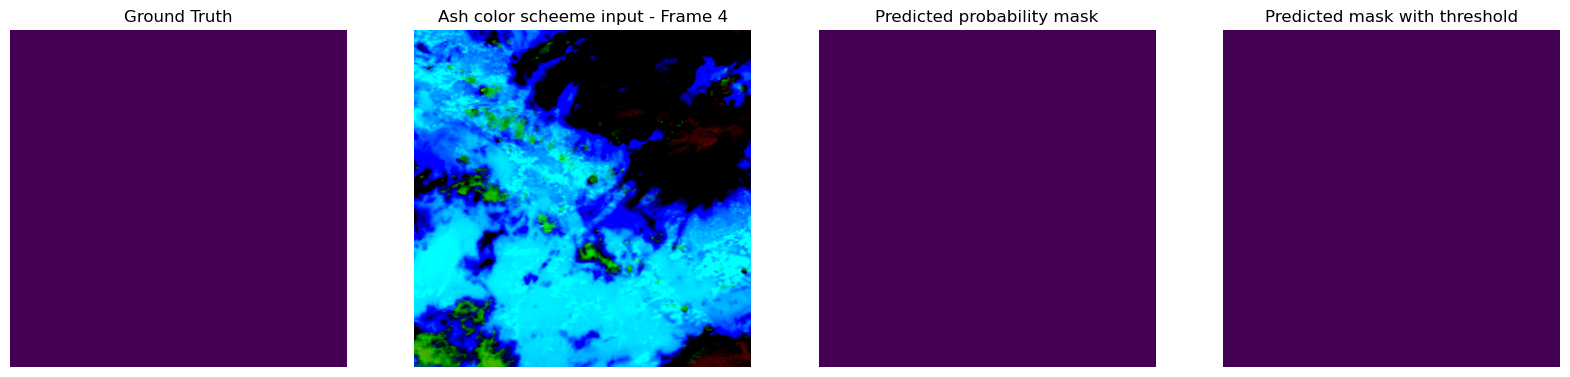

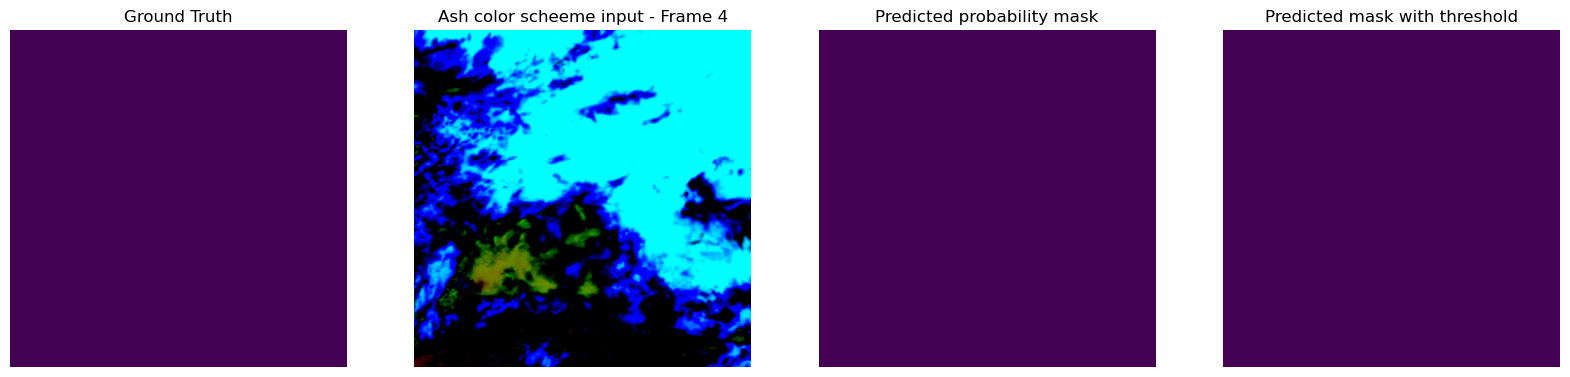

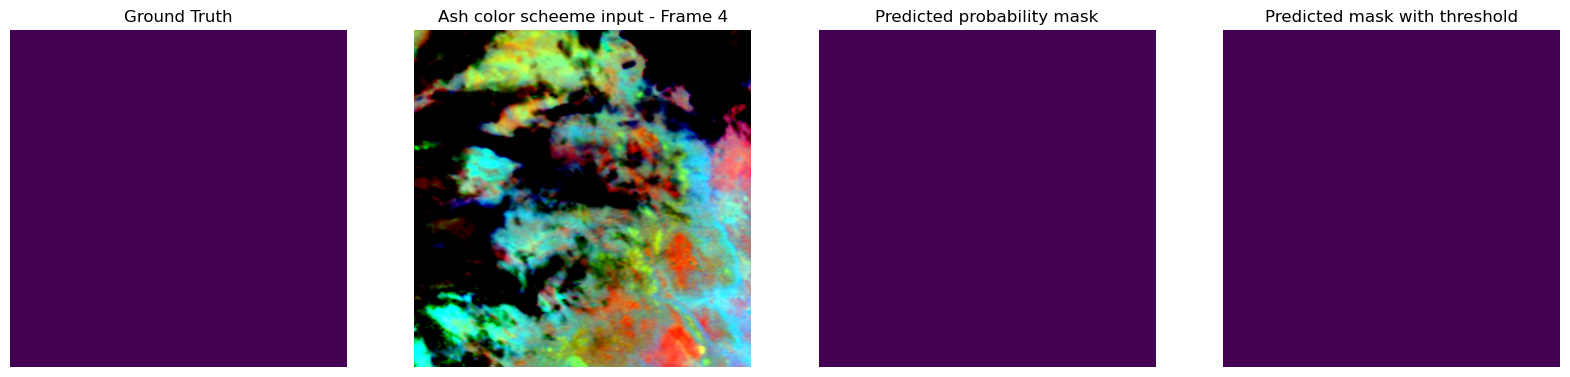

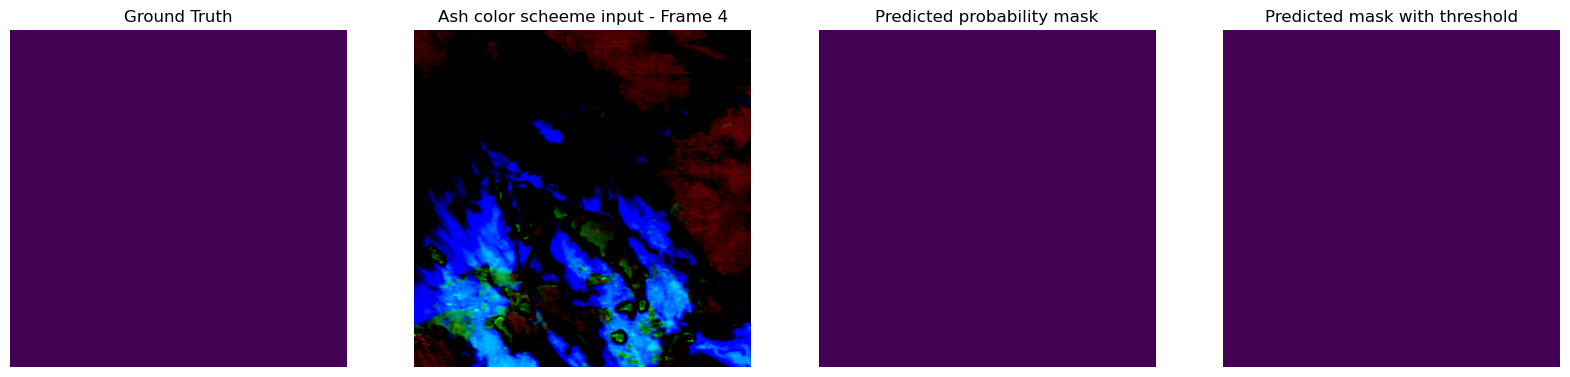

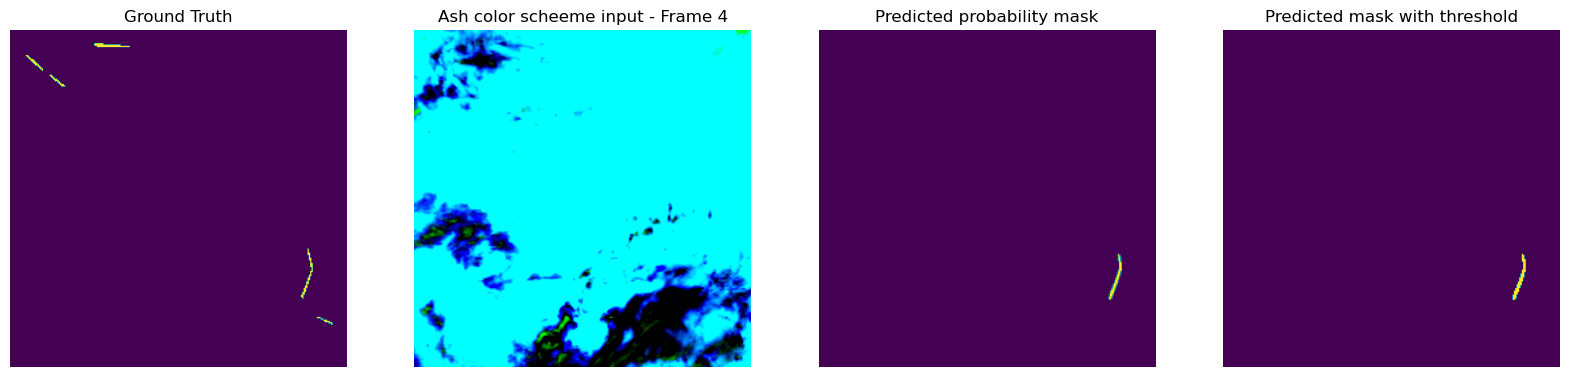

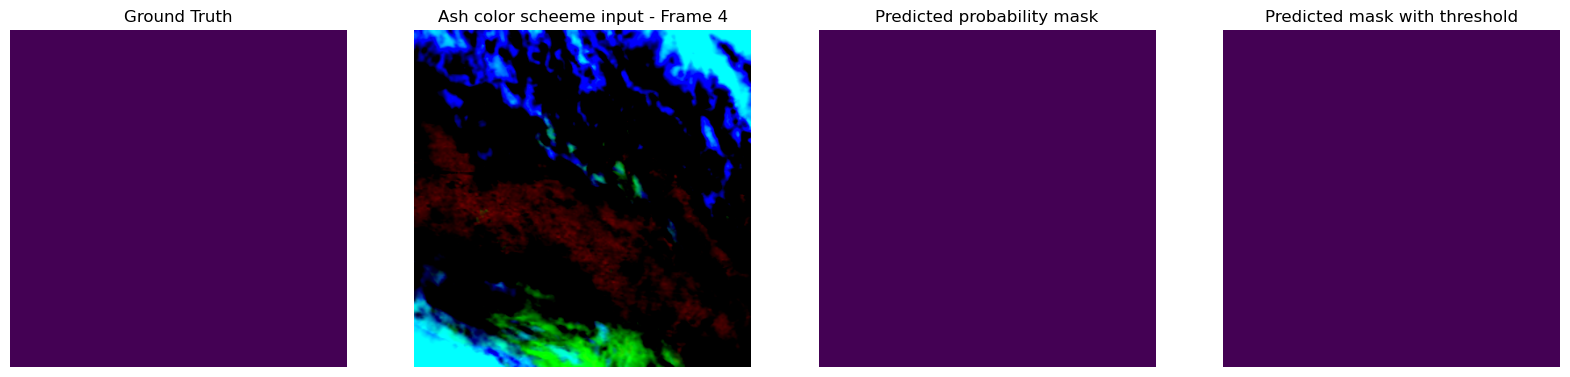

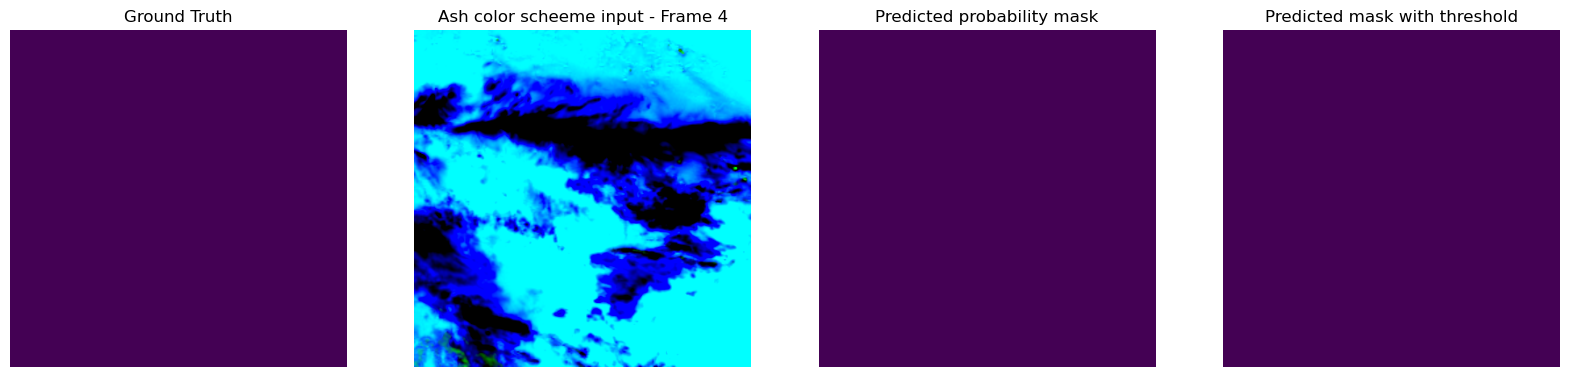

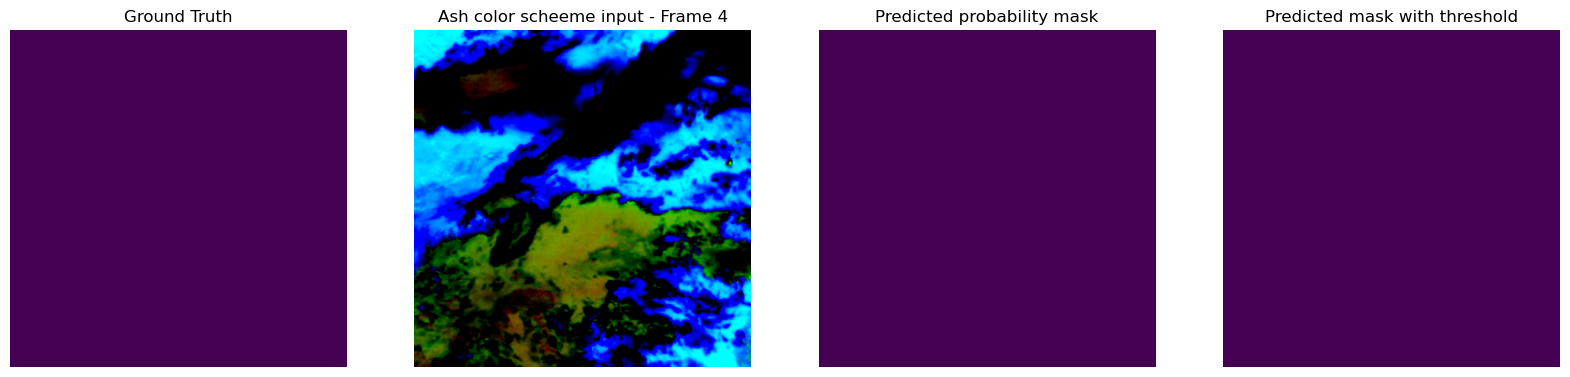

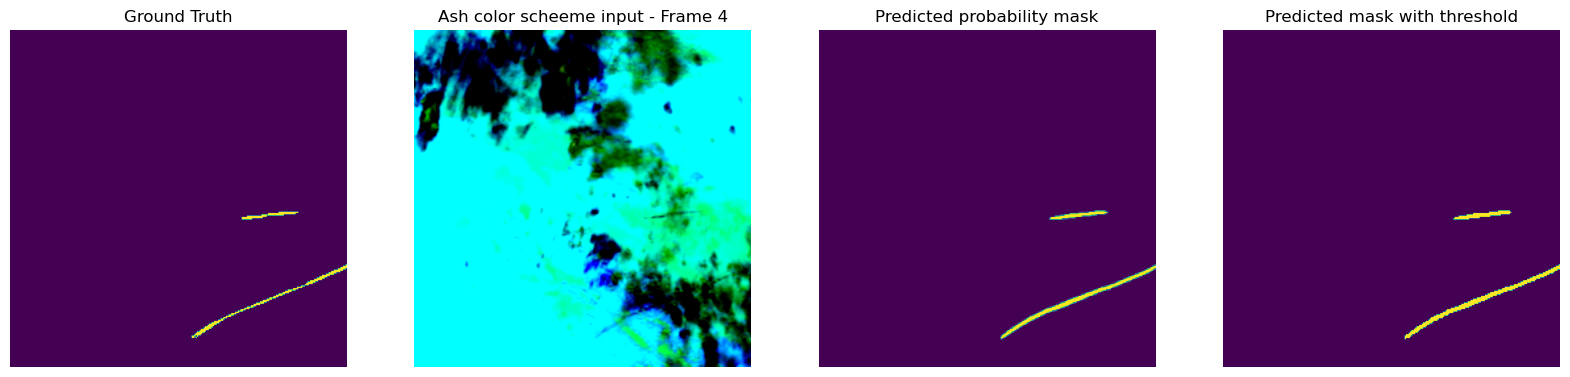

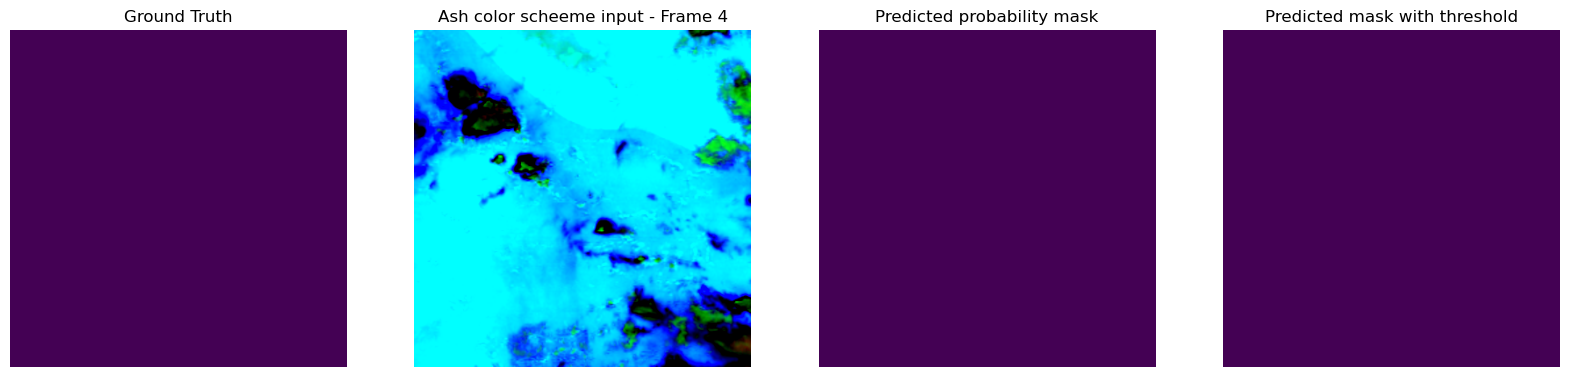

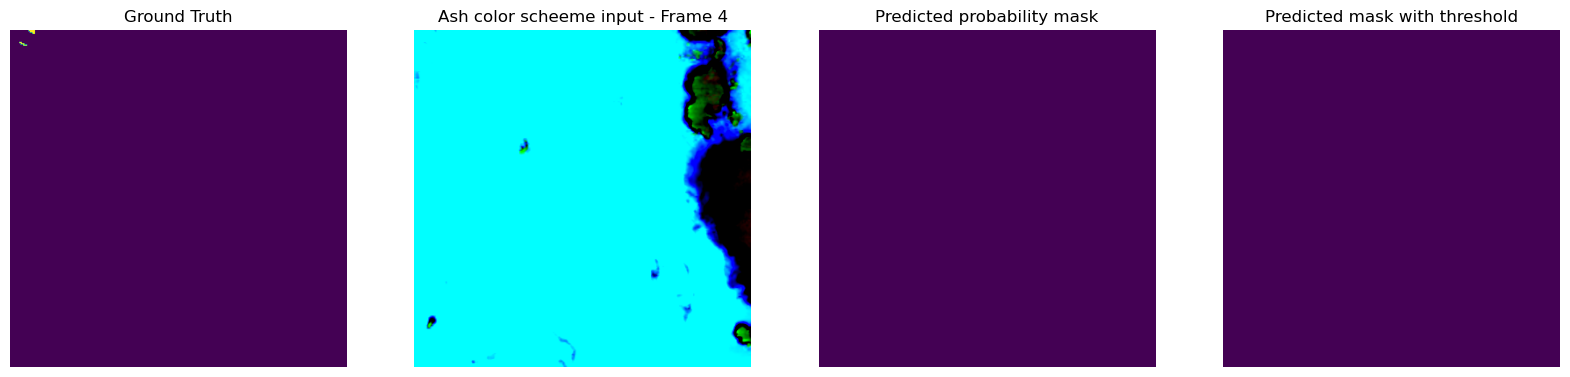

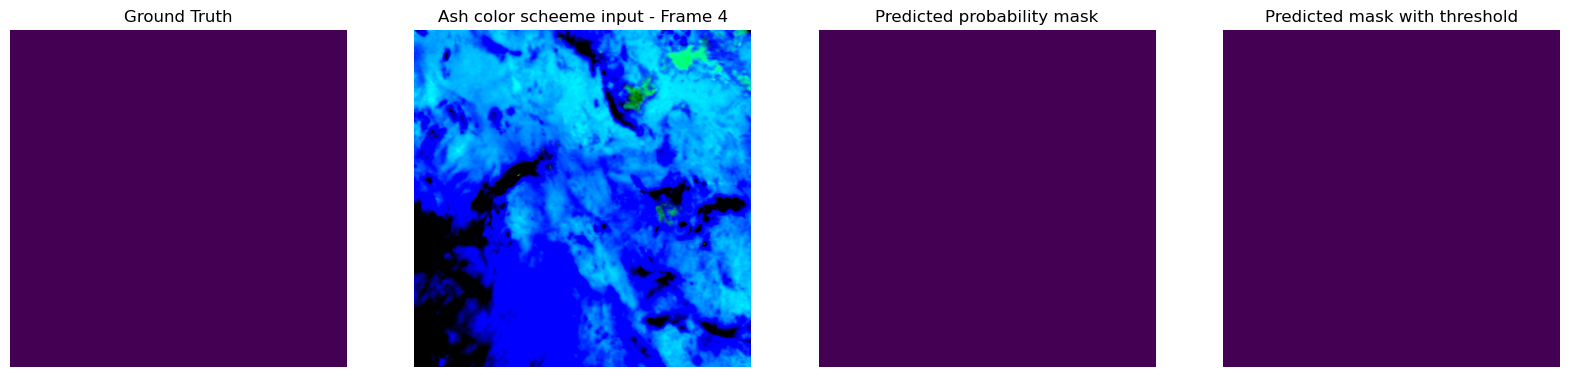

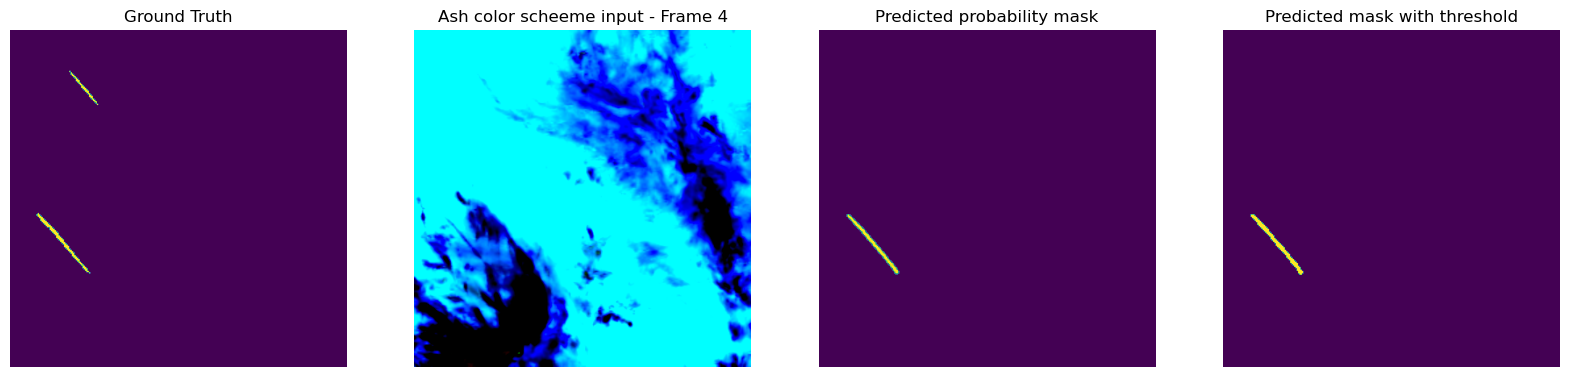

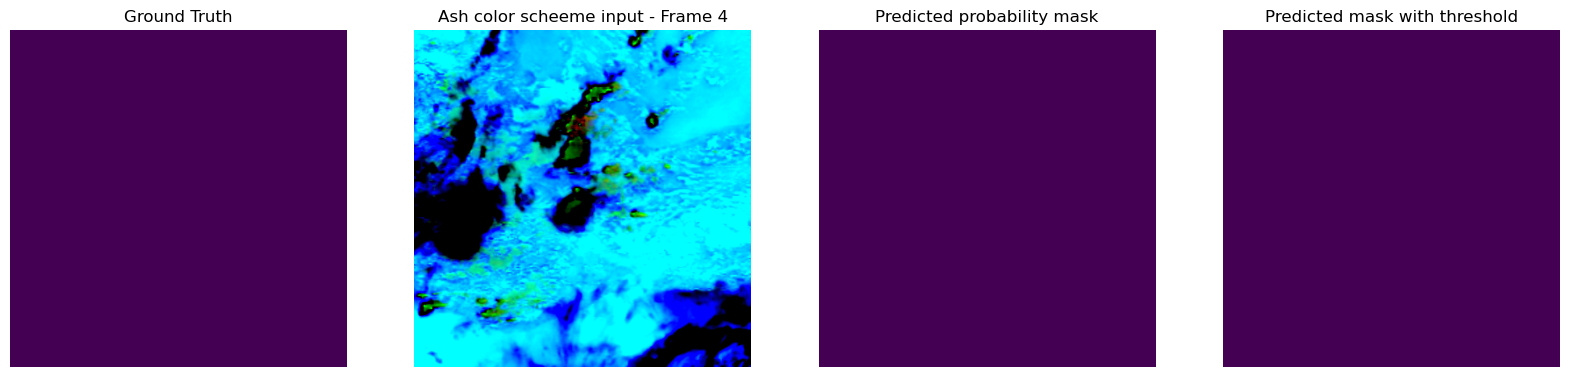

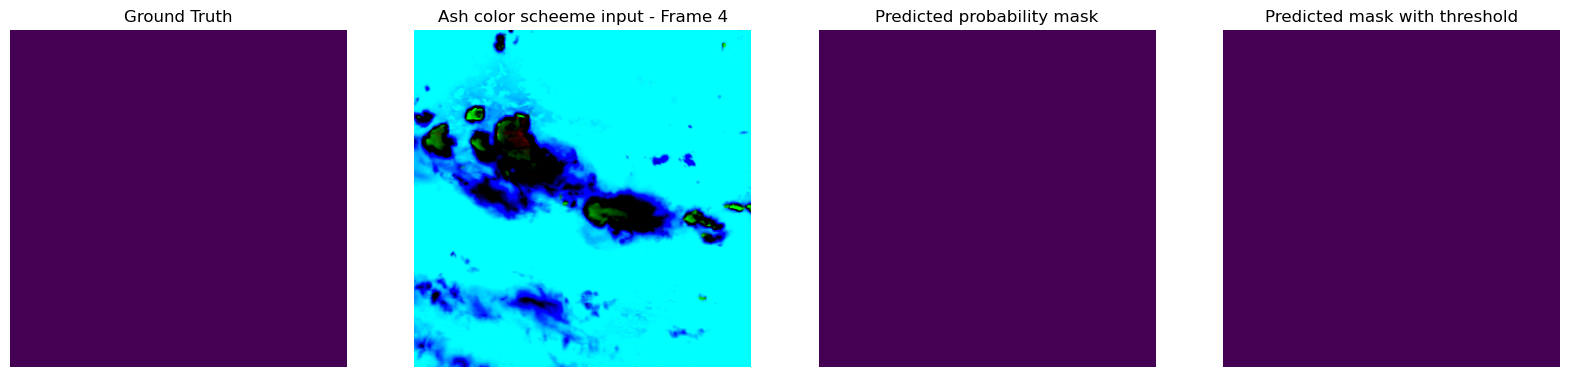

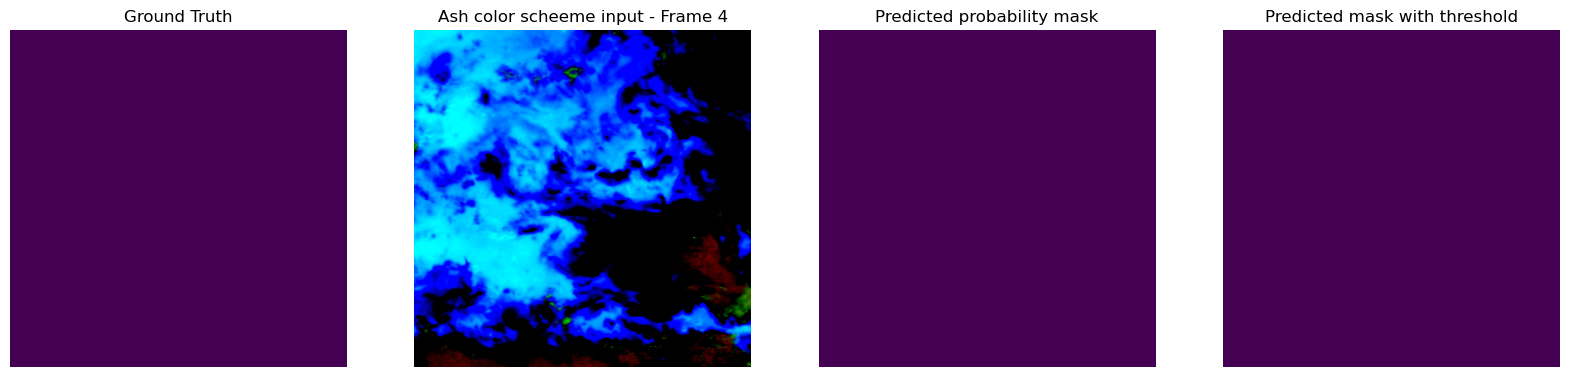

In [18]:
batches_to_show = 2

for i, data in enumerate(val_dl):
    images, mask = data
    
    # Predict mask for this instance
    if torch.cuda.is_available():
        images = images.cuda()
    
        
    predicated_mask = torch.sigmoid(model.forward(images[:, :, :, :]))
    
    if config["model"]["image_size"] != 256:
        predicated_mask = torch.nn.functional.interpolate(predicated_mask, size=256, mode='bilinear').cpu().detach().numpy()
    else:
        predicated_mask = predicated_mask.cpu().detach().numpy()

    
    # Apply threshold
    predicated_mask_with_threshold = np.zeros((images.shape[0], 256, 256))
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] < optim_threshold] = 0
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] > optim_threshold] = 1
    
    images = images.cpu()
        
    for img_num in range(0, images.shape[0]):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,10))
        axes = axes.flatten()
        
        # Show groud trought 
        axes[0].imshow(mask[img_num, 0, :, :])
        axes[0].axis('off')
        axes[0].set_title('Ground Truth')
        
        # Show ash color scheme input image
        axes[1].imshow(images[img_num, :, :, :].permute(1, 2, 0))
        axes[1].axis('off')
        axes[1].set_title('Ash color scheeme input - Frame 4')

        # Show predicted mask
        axes[2].imshow(predicated_mask[img_num, 0, :, :], vmin=0, vmax=1)
        axes[2].axis('off')
        axes[2].set_title('Predicted probability mask')

        # Show predicted mask after threshold
        axes[3].imshow(predicated_mask_with_threshold[img_num, :, :])
        axes[3].axis('off')
        axes[3].set_title('Predicted mask with threshold')
        plt.show()
    
    if i + 1 >= batches_to_show:
        break

# Submission

In [19]:
torch.cuda.empty_cache()

In [20]:
test_df = get_paths('test')

# cast record_id to int
test_df["record_id"] = test_df.record_id.astype(int)

test_ds = ContrailsDataset(
        test_df,
        config["model"]["image_size"],
        train = False
    )

test_batch_size = 1

test_dl = DataLoader(test_ds, batch_size=test_batch_size, num_workers = config["workers"])

del test_ds

In [21]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s

In [22]:
submission = pd.read_csv(os.path.join("/kaggle/input/google-research-identify-contrails-reduce-global-warming", "sample_submission.csv"), index_col='record_id')

In [23]:
for i, images in enumerate(test_dl):
    
    
    image_id = torch.tensor(test_df.iloc[i]['record_id'])
    
    # Predict mask for this instance
    images = images.to(device)
    with torch.no_grad():
        predicted_mask = model.forward(images[:, :, :, :])
        
    if config["model"]["image_size"] != 256:
        predicted_mask = torch.nn.functional.interpolate(predicted_mask, size=256, mode='bilinear')
    predicated_mask = predicted_mask.cpu().detach().numpy()
    
    # Apply threshold
    predicated_mask_with_threshold = np.zeros((images.shape[0], 256, 256))
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] < optim_threshold] = 0
    predicated_mask_with_threshold[predicated_mask[:, 0, :, :] > optim_threshold] = 1
    
    current_mask = predicated_mask_with_threshold[:, :, :]
    current_image_id = image_id.item()
    submission.loc[int(current_image_id), 'encoded_pixels'] = list_to_string(rle_encode(current_mask))

In [24]:
submission.head()

,encoded_pixels
record_id,
1000834164244036115,-
1002653297254493116,-


In [25]:
submission.to_csv('submission.csv')